# Demo 01 - Basic Analysis

The first level of exploratory data analysis we might want to perform is a basic analysis of our available data.  This includes summary statistics, evaluating data structure, and performing growth analysis.

To do this, we will use some built-in R functions as well as functionality available to us in the `tidyverse` package.

In [1]:
if(!require(tidyverse)) {
    install.packages("tidyverse", repos = "http://cran.us.r-project.org")
    library(tidyverse)
}

if(!require(odbc)) {
    install.packages("odbc", repos = "http://cran.us.r-project.org")
    library(odbc)
}

# ggplot2 is installed with the tidyverse.
library(ggplot2)

Loading required package: tidyverse
Warning message:
"package 'tidyverse' was built under R version 3.5.2"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'ggplot2' was built under R version 3.5.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: odbc
Warning message:
"package 'odbc' was built under R version 3.5.3"

## Data Retrieval

In this first section, we will retrieve data for each major table in our data set.  Then we will run summary statistics on each.

In [2]:
conn <- DBI::dbConnect(odbc::odbc(), 
                      Driver = "SQL Server", 
                      Server = "localhost", 
                      Database = "ForensicAccounting", 
                      Trusted_Connection = "True")

In [3]:
buses <- DBI::dbGetQuery(conn, "SELECT BusID, DateFirstInService, DateRetired FROM dbo.Bus;")
employees <- DBI::dbGetQuery(conn, "SELECT EmployeeID, FirstName, LastName FROM dbo.Employee;")
expenseCategories <- DBI::dbGetQuery(conn, "SELECT ExpenseCategoryID, ExpenseCategory FROM dbo.ExpenseCategory;")
vendors <- DBI::dbGetQuery(conn, "SELECT VendorID, VendorName FROM dbo.Vendor;")
vendorExpenseCategories <- DBI::dbGetQuery(conn, "SELECT
	vec.VendorID,
	vec.ExpenseCategoryID,
	v.VendorName,
	ec.ExpenseCategory
FROM dbo.VendorExpenseCategory vec
	INNER JOIN dbo.Vendor v
		ON vec.VendorID = v.VendorID
	INNER JOIN dbo.ExpenseCategory ec
		ON vec.ExpenseCategoryID = ec.ExpenseCategoryID;")

### Buses

In [4]:
str(buses)

'data.frame':	700 obs. of  3 variables:
 $ BusID             : int  1 2 3 4 5 6 7 8 9 10 ...
 $ DateFirstInService: chr  "1990-01-01" "1990-01-01" "1990-01-01" "1990-01-01" ...
 $ DateRetired       : chr  NA "2012-01-01" "2011-01-01" "2013-01-01" ...


The first thing we want to do is clean up the dates.  Then we can get an idea of how long the buses have been in service.

In [5]:
buses$DateFirstInService <- lubridate::ymd(buses$DateFirstInService)
buses$DateRetired <- lubridate::ymd(buses$DateRetired)

In [6]:
summary(buses)
head(buses)

sum(is.na(buses$DateRetired))

     BusID       DateFirstInService    DateRetired        
 Min.   :  1.0   Min.   :1990-01-01   Min.   :2011-01-01  
 1st Qu.:175.8   1st Qu.:1990-01-01   1st Qu.:2012-01-01  
 Median :350.5   Median :2011-07-02   Median :2014-01-01  
 Mean   :350.5   Mean   :2004-01-01   Mean   :2014-03-14  
 3rd Qu.:525.2   3rd Qu.:2015-01-01   3rd Qu.:2016-01-01  
 Max.   :700.0   Max.   :2018-01-01   Max.   :2018-01-01  
                                      NA's   :468         

BusID,DateFirstInService,DateRetired
1,1990-01-01,NA
2,1990-01-01,2012-01-01
3,1990-01-01,2011-01-01
4,1990-01-01,2013-01-01
5,1990-01-01,2017-01-01
6,1990-01-01,NA


[1] 468

There are 700 buses in our total inventory.  468 are still in service as of 2019.

### Employees

We have 12 employees in total.

In [7]:
employees

EmployeeID,FirstName,LastName
1,Jack,Aubrey
2,Stephen,Maturin
3,Sophia,Aubrey
4,Diana,Villiers
5,William,Babbington
6,Barret,Bonden
7,Nathaniel,Martin
8,William,Mowett
9,Ebenezer,Graham
10,Molly,Harte


### Expense Categories

We have 28 expense categories.  Each one has its own rough price but we don't store any of that information directly in the database, as there are different vendors who offer up different prices depending on market circumstances.

In [8]:
expenseCategories %>% arrange(ExpenseCategoryID)

ExpenseCategoryID,ExpenseCategory
1,Vehicle repair labor
2,Vehicle maintenance labor
3,Fuel
4,Lights & Reflectors
5,Switches
6,Electrical
7,Signs & Decals
8,Mirrors
9,Heater & Defroster
10,"Stop Arms, Crossing Gates & Hatches"


### Vendors

There are 15 vendors.  Each vendor has its own specialties.

In [9]:
vendors %>% arrange(VendorID)

VendorID,VendorName
1,Bus Repair Shack
2,VehiCo Parts and Accessories
3,"Fuel Suppliers, Ltd"
4,"Fuel Associates, Unlimited"
5,Glass and Sons Glass and Accessories
6,Electronics and Repairs
7,Clean Sweep Cleaning Supplies
8,Engine Mates
9,Safety First
10,Mobility Accessories R Us


### Vendor Expense Categories

This is a listing of which vendors offer which services.

In [10]:
vendorExpenseCategories %>% arrange(VendorID, ExpenseCategoryID)

VendorID,ExpenseCategoryID,VendorName,ExpenseCategory
1,1,Bus Repair Shack,Vehicle repair labor
1,2,Bus Repair Shack,Vehicle maintenance labor
2,5,VehiCo Parts and Accessories,Switches
2,6,VehiCo Parts and Accessories,Electrical
2,7,VehiCo Parts and Accessories,Signs & Decals
2,12,VehiCo Parts and Accessories,Seats & Seat Belts
2,13,VehiCo Parts and Accessories,Radio / PA
2,16,VehiCo Parts and Accessories,Child Seats & Restraints
2,17,VehiCo Parts and Accessories,Wheelchair Tie-Downs
3,3,"Fuel Suppliers, Ltd",Fuel


We can easily see how many different categories each vendor offers.

In [11]:
vendorExpenseCategories %>%
    group_by(VendorID, VendorName) %>%
    summarize(n = n())

VendorID,VendorName,n
1,Bus Repair Shack,2
2,VehiCo Parts and Accessories,7
3,"Fuel Suppliers, Ltd",1
4,"Fuel Associates, Unlimited",1
5,Glass and Sons Glass and Accessories,4
6,Electronics and Repairs,4
7,Clean Sweep Cleaning Supplies,6
8,Engine Mates,7
9,Safety First,12
10,Mobility Accessories R Us,4


We can also see that there are a few sole-source suppliers.  In an audit, we might investigate the reason why we would have sole-source suppliers in these categories.

In [12]:
vendorExpenseCategories %>%
    group_by(ExpenseCategoryID, ExpenseCategory) %>%
    summarize(n = n())

ExpenseCategoryID,ExpenseCategory,n
1,Vehicle repair labor,2
2,Vehicle maintenance labor,3
3,Fuel,2
4,Lights & Reflectors,2
5,Switches,3
6,Electrical,2
7,Signs & Decals,4
8,Mirrors,2
9,Heater & Defroster,4
10,"Stop Arms, Crossing Gates & Hatches",1


## Growth Analysis

In this section, we want to see how things have changed over time.

### Active Buses

The first thing we will look at is how many active buses the agency has at its disposal each year.  To make things simpler, we add new buses and take buses out of service once a year.

In [13]:
activeBuses <- DBI::dbGetQuery(conn, "SELECT
	c.CalendarYear,
	COUNT(*) AS NumberOfBuses
FROM dbo.Bus b
	INNER JOIN dbo.Calendar c
		ON b.DateFirstInService <= c.Date
		AND ISNULL(b.DateRetired, '2018-12-31') >= c.Date
WHERE
	c.CalendarDayOfYear = 1
	AND c.CalendarYear >= 2011
	AND c.CalendarYear < 2019
GROUP BY
	c.CalendarYear
ORDER BY
	c.CalendarYear;")

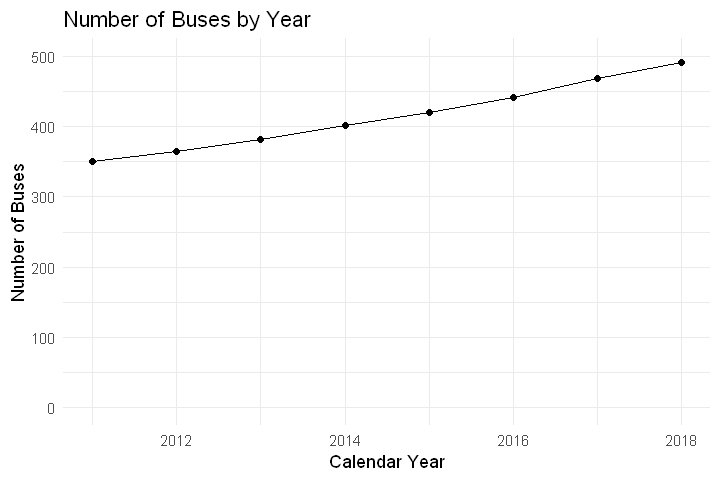

In [14]:
options(repr.plot.width=6, repr.plot.height=4) 
ggplot(activeBuses, aes(x = CalendarYear, y = NumberOfBuses)) +
    geom_point() +
    geom_line() +
    labs(x = "Calendar Year", y = "Number of Buses", title = "Number of Buses by Year") +
    ylim(0, 500) +
    theme_minimal()

We see a steady increase in the number of buses by year.  The number of buses is likely the biggest driver for our expenses, so we'd expect to see similar growth over time in expenses.

### Invoices Per Year

The next thing we want to look at is the number of invoices per year our staff handle.

In [15]:
invoicesPerYear <- DBI::dbGetQuery(conn, "SELECT
	c.CalendarYear,
	COUNT(*) AS NumberOfInvoices
FROM dbo.LineItem li
	INNER JOIN dbo.Calendar c
		ON li.LineItemDate = c.Date
GROUP BY
	c.CalendarYear
ORDER BY
	c.CalendarYear;")

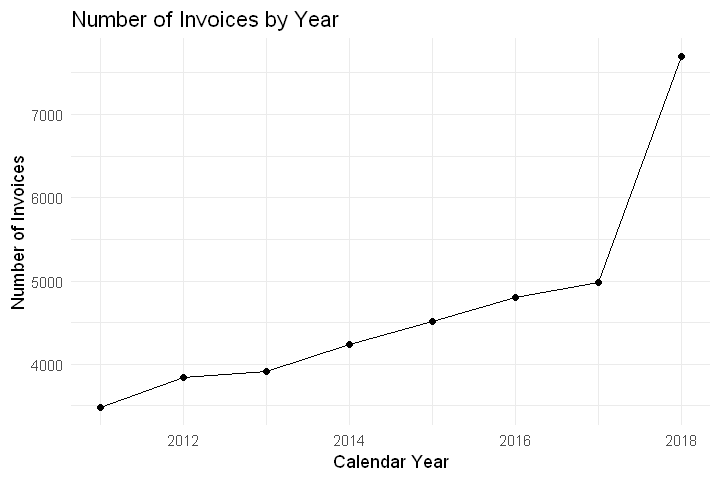

In [16]:
ggplot(invoicesPerYear, aes(x = CalendarYear, y = NumberOfInvoices)) +
    geom_point() +
    geom_line() +
    labs(x = "Calendar Year", y = "Number of Invoices", title = "Number of Invoices by Year") +
    theme_minimal()

We can see steady growth through most of the time frame but a huge spike in 2018.  This looks very weird.

### Expenditures Per Year

Knowing that we saw a spike in invoices it would also be illustrative to review the amount of money we spend per year.

In [17]:
expendituresPerYear <- DBI::dbGetQuery(conn, "SELECT
	c.CalendarYear,
	SUM(li.Amount) AS TotalInvoicedAmount
FROM dbo.LineItem li
	INNER JOIN dbo.Calendar c
		ON li.LineItemDate = c.Date
GROUP BY
	c.CalendarYear
ORDER BY
	c.CalendarYear;")

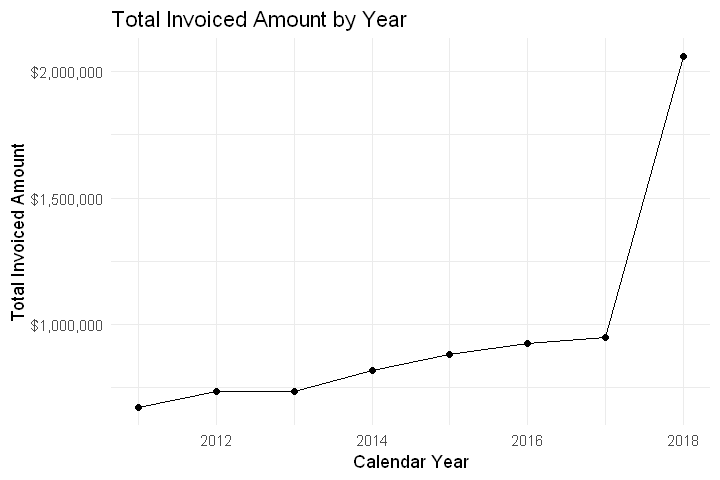

In [18]:
ggplot(expendituresPerYear, aes(x = CalendarYear, y = TotalInvoicedAmount)) +
    geom_point() +
    geom_line() +
    scale_y_continuous(labels = scales::dollar) +
    labs(x = "Calendar Year", y = "Total Invoiced Amount", title = "Total Invoiced Amount by Year") +
    theme_minimal()

This is looking suspicious.  We were a little under \$1 million in 2017 and jump up over \$2 million in 2018.  Yes, there are more buses in the fleet in 2018 but that's a sharp incline.  We'll need to do more research and get back to it.